SAM 3 (Segment Anything Model 3) extends the SAM series by moving from segmenting individual objects to understanding and segmenting all instances of a concept in images and videos. It introduces Promptable Concept Segmentation (PCS), where users specify a concept through short noun phrases like “striped cat” or by providing visual exemplars. The model detects, segments, and tracks every matching object, preserving identities across frames.


## Environment setup

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM 3 checkpoints.

- Request access to the SAM 3 checkpoints on the official Hugging Face [repo](https://github.com/facebookresearch/sam3).
- Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
- In Colab, go to the left pane and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.








In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
# @title
!nvidia-smi

Tue Nov 25 18:18:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [4]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

Cloning into 'sam3'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 572 (delta 47), reused 36 (delta 36), pack-reused 429 (from 2)
Receiving objects: 100% (572/572), 58.94 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1

/content


In [3]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 5.7 MB/s eta 0:00:00


## Restart before running below cell

## Load SAM3 Image Predictor

On Ampere GPUs (compute capability ≥ 8), we enable TensorFloat-32 (TF32) for matrix multiplications and convolutions. This allows PyTorch to use tensor cores to accelerate FP32 computations while maintaining similar numerical accuracy.

In [4]:
import torch

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [5]:
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

model = build_sam3_image_model()
processor = Sam3Processor(model, confidence_threshold=0.3)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

## Few utils to parse and visualize the result

In [6]:
import supervision as sv

def from_sam(sam_result: dict) -> sv.Detections:
    xyxy = sam_result["boxes"].to(torch.float32).cpu().numpy()
    confidence = sam_result["scores"].to(torch.float32).cpu().numpy()

    mask = sam_result["masks"].to(torch.bool)
    mask = mask.reshape(mask.shape[0], mask.shape[2], mask.shape[3]).cpu().numpy()

    return sv.Detections(
        xyxy=xyxy,
        confidence=confidence,
        mask=mask
    )

In [69]:
import supervision as sv
from PIL import Image
from typing import Optional


COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])


def annotate(image: Image.Image, detections: sv.Detections, label: Optional[str] = None) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )
    box_annotator = sv.BoxAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        thickness=1
    )
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.4,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)

    if label:
        labels = [
            f"{label} {confidence:.2f}"
            for confidence in detections.confidence
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

## SAM 3 text prompt

There are 6 vertical pillar objects detected in the image.



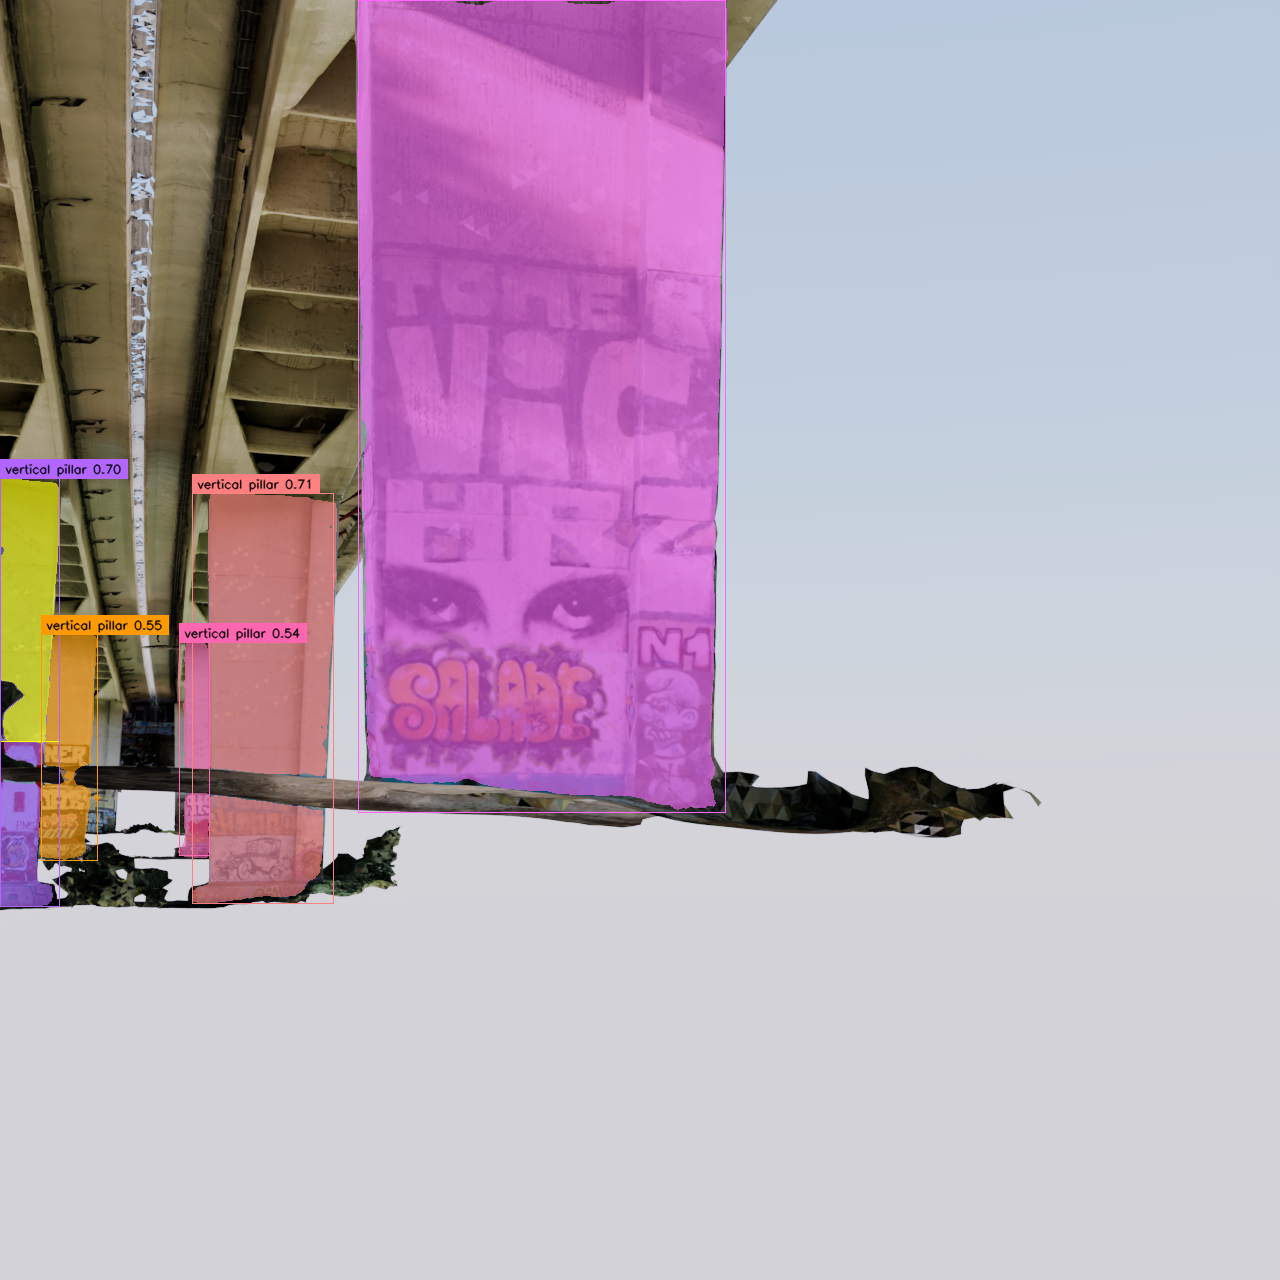

In [70]:
from PIL import Image
from IPython.display import display

PROMPT = "vertical pillar"
IMAGE_PATH = '/content/Data/rgb_00000.png'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=PROMPT)

There are 3 bridge road objects detected in the image.

There are 3 guardrail objects detected in the image.



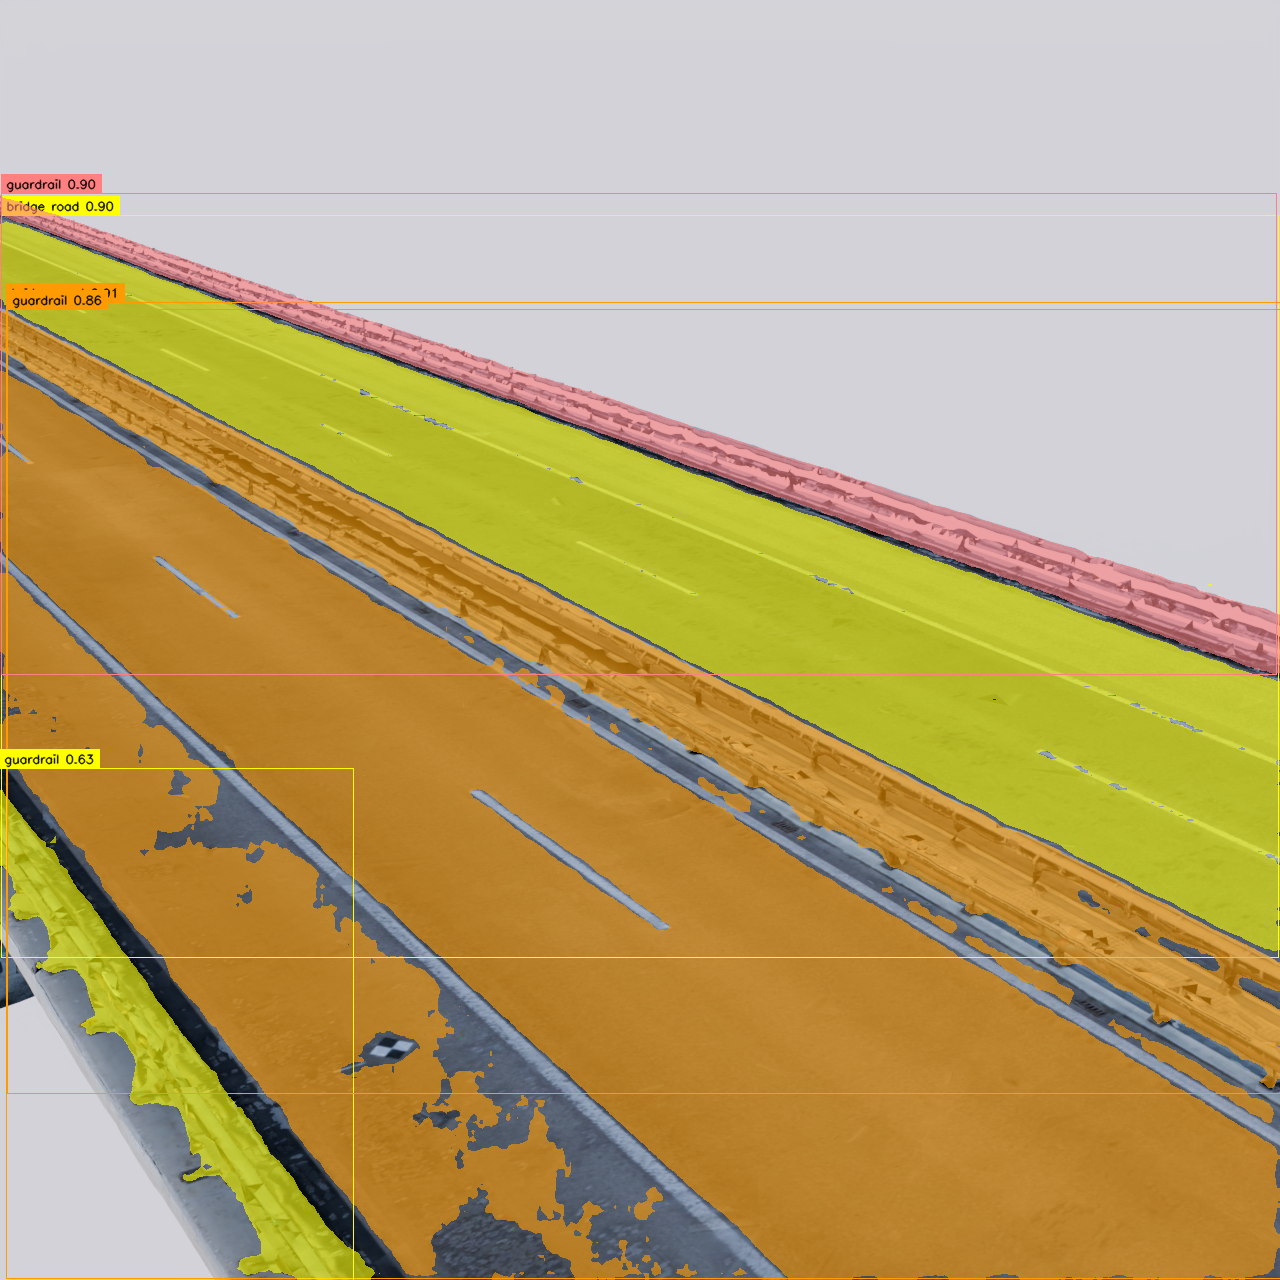

In [52]:
from PIL import Image
from IPython.display import display

PROMPT_1 = "bridge road"
PROMPT_2 = "guardrail"

IMAGE_PATH = '/content/Data/rgb_00018.png'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_1)
detections = from_sam(sam_result=inference_state)
detections_1 = detections[detections.confidence > 0.3]

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_2)
detections = from_sam(sam_result=inference_state)
detections_2 = detections[detections.confidence > 0.3]




print(f"There are {len(detections)} {PROMPT_1} objects detected in the image.\n")
print(f"There are {len(detections)} {PROMPT_2} objects detected in the image.\n")


image = annotate(image, detections_1, label=PROMPT_1)
image = annotate(image, detections_2, label=PROMPT_2)

image

# Batch Processing

### 1. Libraries

In [16]:
# @title
!pip install -q opencv-python scipy pycocotools tqdm

import numpy as np
import cv2
import json
from pathlib import Path
from collections import Counter
from tqdm import tqdm
from pycocotools import mask as mask_util
import math

print(" Additional dependencies installed!")

✓ Additional dependencies installed!


2. Masks post process

In [85]:
# @title
def post_process_masks(masks,
                       fill_holes=True,
                       close_gaps=True,
                       remove_sprinkles=False,
                       max_hole_area=8000,
                       closing_kernel_size=100,
                       max_sprinkle_area=100):
    """
    Advanced mask post-processing to fix incomplete SAM3 masks.

    This function addresses masks with missing parts inside bounding boxes by:
    1. Closing gaps using morphological operations
    2. Filling enclosed holes
    3. Removing noise/sprinkles

    Args:
        masks: numpy array of shape (n, H, W) - binary masks
        fill_holes: If True, fill holes completely enclosed by foreground
        close_gaps: If True, use morphological closing to connect broken regions
        remove_sprinkles: If True, remove small isolated foreground regions
        max_hole_area: Maximum area (pixels) of holes to fill (default: 8000)
        closing_kernel_size: Size of kernel for morphological closing (default: 100)
        max_sprinkle_area: Maximum area (pixels) of sprinkles to remove (default: 100)

    Returns:
        Processed masks with gaps closed, holes filled, and noise removed
    """
    if len(masks) == 0:
        return masks

    from scipy.ndimage import binary_fill_holes, label as scipy_label
    import cv2

    n = len(masks)
    processed_masks = masks.copy()

    if fill_holes or close_gaps or remove_sprinkles:
        operations = []
        if close_gaps:
            operations.append("closing gaps")
        if fill_holes:
            operations.append("filling holes")
        if remove_sprinkles:
            operations.append("removing sprinkles")
        print(f"\n Processing: {', '.join(operations)}...")

        gaps_closed = 0
        holes_filled = 0
        sprinkles_removed = 0

        for i in range(n):
            mask = processed_masks[i]
            mask_bool = mask.astype(bool)

            # Step 1: Morphological closing to connect broken regions
            if close_gaps and closing_kernel_size > 0:
                kernel = cv2.getStructuringElement(
                    cv2.MORPH_ELLIPSE,
                    (closing_kernel_size, closing_kernel_size)
                )
                mask_uint8 = mask_bool.astype(np.uint8)
                closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
                mask_bool = closed.astype(bool)

                pixels_added = np.sum(mask_bool & ~processed_masks[i].astype(bool))
                if pixels_added > 0:
                    gaps_closed += 1

                processed_masks[i] = mask_bool

            # Step 2: Fill completely enclosed holes
            if fill_holes:
                filled = binary_fill_holes(mask_bool)
                holes = filled & ~mask_bool
                labeled_holes, num_holes = scipy_label(holes)

                for hole_id in range(1, num_holes + 1):
                    hole_mask = (labeled_holes == hole_id)
                    hole_area = np.sum(hole_mask)

                    if hole_area <= max_hole_area:
                        mask_bool[hole_mask] = True
                        holes_filled += 1

                processed_masks[i] = mask_bool

            # Step 3: Remove small isolated foreground regions
            if remove_sprinkles and max_sprinkle_area > 0:
                labeled_regions, num_regions = scipy_label(mask_bool)

                if num_regions > 0:
                    region_sizes = [(region_id, np.sum(labeled_regions == region_id))
                                   for region_id in range(1, num_regions + 1)]

                    for region_id, region_size in region_sizes:
                        if region_size <= max_sprinkle_area:
                            region_mask = (labeled_regions == region_id)
                            mask_bool[region_mask] = False
                            sprinkles_removed += 1

                processed_masks[i] = mask_bool

        # Print summary
        status_parts = []
        if close_gaps and gaps_closed > 0:
            status_parts.append(f"{gaps_closed} masks closed (kernel={closing_kernel_size})")
        if fill_holes and holes_filled > 0:
            status_parts.append(f"{holes_filled} holes filled (≤{max_hole_area}px)")
        if remove_sprinkles and sprinkles_removed > 0:
            status_parts.append(f"{sprinkles_removed} sprinkles removed (≤{max_sprinkle_area}px)")

        if status_parts:
            print(f"    {', '.join(status_parts)}")
        else:
            print(f"    No changes needed")
    else:
        print(f"\n Skipping post-processing")

    return processed_masks

print(" Advanced mask post-processing function defined!")
print("   Features: gap closing, hole filling, noise removal")

 Advanced mask post-processing function defined!
   Features: gap closing, hole filling, noise removal


### 3. Consistent ID

In [86]:
# @title
def get_consistent_class_mapping(class_names, text_prompts):
    """
    Create consistent class IDs based on text prompt order.
    First prompt = ID 0, second = ID 1, etc.

    Args:
        class_names: List of class names detected
        text_prompts: List of text prompts (e.g., ["concrete pillar", "bridge deck"])

    Returns:
        Dictionary {class_name: class_id}
    """
    # Get unique detected classes
    unique_classes = list(set(class_names))

    # Map each detected class to prompt order
    class_to_id = {}
    for class_name in unique_classes:
        class_lower = class_name.lower()
        # Find matching prompt
        for idx, prompt in enumerate(text_prompts):
            prompt_lower = prompt.lower()
            if class_lower == prompt_lower or prompt_lower in class_lower or class_lower in prompt_lower:
                class_to_id[class_name] = idx
                break
        # If not found, assign next ID
        if class_name not in class_to_id:
            class_to_id[class_name] = len(text_prompts)

    return class_to_id

print(" Class mapping function defined!")

 Class mapping function defined!


### 4. Text prompts and threshold

#### from google.colab import drive
#### drive.mount('/content/drive')

In [153]:
# @title
# ==================== ADVANCED BATCH PROCESSING CONFIGURATION ====================

# Input/Output directories
IMAGES_DIRECTORY = "/content/Data"  # Input images folder
BATCH_OUTPUT_DIR = Path("/content/SAM3_batch_results2")  # Output folder
BATCH_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Image file extensions to process
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png', 'bmp']

# Text prompts for detection with individual confidence thresholds
# Format: (prompt, confidence_threshold)
TEXT_PROMPTS = [
    ("concrete beam", 0.45),      # Confidence threshold for concrete beam
    ("vertical column", 0.6),    # Confidence threshold for vertical column
    ("bridge road", 0.7),         # Confidence threshold for bridge deck
    ("red steel support", 0.4),
    ("guardrail", 0.5)
]

# Image range configuration
BATCH_START_INDEX = 0      # Start from this image (0-based)
BATCH_END_INDEX = 160       # Process up to this image (exclusive)
# Or set BATCH_END_INDEX = None to process all images from BATCH_START_INDEX

# Post-processing configuration
ENABLE_POST_PROCESSING = True
POST_PROCESS_CONFIG = {
    'fill_holes': False,
    'close_gaps': False,
    'remove_sprinkles': False,
    'max_hole_area': 8000,
    'closing_kernel_size': 100,
    'max_sprinkle_area': 100
}

print(" Advanced Batch Processing Configuration:")
print(f"   Input: {IMAGES_DIRECTORY}")
print(f"   Output: {BATCH_OUTPUT_DIR}")
print(f"   Text prompts: {TEXT_PROMPTS}")
print(f"   Range: {BATCH_START_INDEX} to {BATCH_END_INDEX if BATCH_END_INDEX else 'end'}")
print(f"   Post-processing: {'Enabled' if ENABLE_POST_PROCESSING else 'Disabled'}")
print(f"   Model: SAM 3 (native text-based detection + segmentation)")

 Advanced Batch Processing Configuration:
   Input: /content/Data
   Output: /content/SAM3_batch_results2
   Text prompts: [('concrete beam', 0.45), ('vertical column', 0.6), ('bridge road', 0.7), ('red steel support', 0.4), ('guardrail', 0.5)]
   Range: 0 to 160
   Post-processing: Enabled
   Model: SAM 3 (native text-based detection + segmentation)


## 5. Collect images

In [154]:
# @title
import glob

# Collect all image files
def get_image_files(directory, extensions):
    """Get all image files from directory with specified extensions"""
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(directory, f"*.{ext.lower()}")))
        image_files.extend(glob.glob(os.path.join(directory, f"*.{ext.upper()}")))
    return sorted(list(set(image_files)))

all_image_files = get_image_files(IMAGES_DIRECTORY, IMAGES_EXTENSIONS)
print(f"Found {len(all_image_files)} total images")

# Select range
if BATCH_END_INDEX is None:
    BATCH_END_INDEX = len(all_image_files)

BATCH_START_INDEX = max(0, min(BATCH_START_INDEX, len(all_image_files)))
BATCH_END_INDEX = max(BATCH_START_INDEX, min(BATCH_END_INDEX, len(all_image_files)))

batch_image_files = all_image_files[BATCH_START_INDEX:BATCH_END_INDEX]

print(f"\n Will process {len(batch_image_files)} images (index {BATCH_START_INDEX} to {BATCH_END_INDEX-1})")
for i, img_file in enumerate(batch_image_files[:5]):
    print(f"   {BATCH_START_INDEX + i}: {os.path.basename(img_file)}")
if len(batch_image_files) > 5:
    print(f"   ... and {len(batch_image_files) - 5} more")

Found 156 total images

 Will process 156 images (index 0 to 155)
   0: rgb_00000.png
   1: rgb_00001.png
   2: rgb_00002.png
   3: rgb_00006.png
   4: rgb_00007.png
   ... and 151 more


### 6. Process images

In [155]:
# @title
def process_single_image_sam3(img_path, sam3_processor, text_prompts, enable_post_processing=True, post_process_config=None):
    """Process a single image with SAM 3 native detection + segmentation"""
    try:
        # Load image
        pil_image = Image.open(img_path).convert("RGB")
        image_np = np.array(pil_image)
        h, w = image_np.shape[:2] if len(image_np.shape) == 3 else (image_np.shape[0], image_np.shape[1])

        # Set image in SAM 3 processor (once for all prompts)
        inference_state = sam3_processor.set_image(pil_image)

        # Process each text prompt
        all_masks = []
        all_boxes = []
        all_scores = []
        all_labels = []

        print(f"\n Processing {os.path.basename(img_path)}...")

        for prompt_config in text_prompts:
            # Extract prompt and threshold (support both tuple and string formats)
            if isinstance(prompt_config, tuple):
                prompt, confidence_threshold = prompt_config
            else:
                prompt = prompt_config
                confidence_threshold = 0.3  # Default threshold

            # SAM 3 native text-based detection + segmentation
            inference_state = sam3_processor.set_text_prompt(
                state=inference_state,
                prompt=prompt
            )

            # Extract results from inference state
            detections_sam = from_sam(sam_result=inference_state)

            # Apply per-class confidence threshold
            detections_sam = detections_sam[detections_sam.confidence > confidence_threshold]

            if len(detections_sam) > 0:
                print(f"    '{prompt}': {len(detections_sam)} detections (threshold={confidence_threshold})")

                # Collect results
                for idx in range(len(detections_sam)):
                    all_masks.append(detections_sam.mask[idx])
                    all_boxes.append(detections_sam.xyxy[idx])
                    all_scores.append(detections_sam.confidence[idx])
                    all_labels.append(prompt)
            else:
                print(f"    '{prompt}': no detections (threshold={confidence_threshold})")

        if len(all_masks) == 0:
            print(f"    No detections found")
            return None

        # Convert to numpy arrays
        masks = np.array(all_masks)
        boxes = np.array(all_boxes)
        scores = np.array(all_scores)

        # Create class mapping first (extract prompt names from tuples)
        prompt_names = [p[0] if isinstance(p, tuple) else p for p in text_prompts]
        class_name_to_id = get_consistent_class_mapping(all_labels, prompt_names)
        class_ids = np.array([class_name_to_id[name] for name in all_labels])

        # Create temporary detections for NMS
        temp_detections = sv.Detections(
            xyxy=boxes,
            confidence=scores,
            class_id=class_ids,
            mask=masks.astype(bool)
        )

        # Apply NMS with IoU threshold of 0.5 (adjust if needed)
        nms_detections = temp_detections.with_nms(threshold=0.5)

        # Extract NMS results
        nms_indices = []
        for i, box in enumerate(nms_detections.xyxy):
            # Find matching box in original detections
            for j, orig_box in enumerate(boxes):
                if np.allclose(box, orig_box):
                    nms_indices.append(j)
                    break

        # Filter all arrays by NMS indices
        masks = masks[nms_indices]
        boxes = boxes[nms_indices]
        scores = scores[nms_indices]
        all_labels = [all_labels[i] for i in nms_indices]
        class_ids = class_ids[nms_indices]

        print(f"    Reduced from {len(temp_detections)} to {len(masks)} detections (removed {len(temp_detections) - len(masks)} overlaps)")

        # Apply advanced post-processing if enabled
        if enable_post_processing and post_process_config:
            masks = post_process_masks(masks=masks, **post_process_config)

        unique_class_names = list(set(all_labels))

        # Create detection labels with confidence scores
        confidences = scores.tolist() if hasattr(scores, 'tolist') else list(scores)
        detection_labels = [f"{label} {conf:.2f}" for label, conf in zip(all_labels, confidences)]

        # Create supervision Detections object
        detections = sv.Detections(
            xyxy=boxes,
            mask=masks.astype(bool),
            class_id=class_ids
        )

        return {
            'image_path': img_path,
            'image_source': image_np,
            'detections': detections,
            'labels': detection_labels,
            'class_names': all_labels,
            'confidences': confidences,
            'masks': masks,
            'scores': scores,
            'input_boxes': boxes,
            'unique_class_names': unique_class_names,
            'class_name_to_id': class_name_to_id
        }

    except Exception as e:
        print(f" Error processing {os.path.basename(img_path)}: {e}")
        import traceback
        traceback.print_exc()
        return None

# Process all images
batch_results = []
print(f"\n Processing {len(batch_image_files)} images with SAM 3...")

for img_file in tqdm(batch_image_files, desc="Processing"):
    result = process_single_image_sam3(
        img_file,
        processor,
        TEXT_PROMPTS,
        enable_post_processing=ENABLE_POST_PROCESSING,
        post_process_config=POST_PROCESS_CONFIG if ENABLE_POST_PROCESSING else None
    )
    if result:
        batch_results.append(result)

print(f"\n Successfully processed {len(batch_results)}/{len(batch_image_files)} images")


 Processing 156 images with SAM 3...


Processing:   0%|          | 0/156 [00:00<?, ?it/s]


 Processing rgb_00000.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   1%|          | 1/156 [00:05<13:53,  5.38s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00001.png...
    'concrete beam': 16 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:   1%|▏         | 2/156 [00:11<14:20,  5.59s/it]

    Reduced from 21 to 21 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00002.png...
    'concrete beam': 7 detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   2%|▏         | 3/156 [00:16<14:17,  5.60s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 8 to 8 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00006.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   3%|▎         | 4/156 [00:22<14:14,  5.62s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 8 to 7 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00007.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   3%|▎         | 5/156 [00:27<14:02,  5.58s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00008.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   4%|▍         | 6/156 [00:33<13:45,  5.51s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00009.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 5 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:   4%|▍         | 7/156 [00:38<13:37,  5.49s/it]

    Reduced from 15 to 15 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00010.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 8 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 12 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:   5%|▌         | 8/156 [00:44<13:31,  5.48s/it]

    Reduced from 20 to 20 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00013.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   6%|▌         | 9/156 [00:49<13:12,  5.39s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 7 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00014.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)
    Reduced from 13 to 13 detections (removed 0 overlaps)

 Skipping post-processing


Processing:   6%|▋         | 10/156 [00:54<13:01,  5.36s/it]


 Processing rgb_00015.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:   7%|▋         | 11/156 [01:00<13:11,  5.46s/it]

    Reduced from 20 to 20 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00016.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 12 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:   8%|▊         | 12/156 [01:05<13:05,  5.45s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00018.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   8%|▊         | 13/156 [01:10<12:46,  5.36s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00019.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:   9%|▉         | 14/156 [01:16<12:30,  5.29s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00020.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  10%|▉         | 15/156 [01:21<12:19,  5.24s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00022.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  10%|█         | 16/156 [01:26<12:12,  5.23s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00023.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  11%|█         | 17/156 [01:31<12:09,  5.25s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00024.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  12%|█▏        | 18/156 [01:36<12:07,  5.27s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00027.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  12%|█▏        | 19/156 [01:42<12:06,  5.31s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00028.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  13%|█▎        | 20/156 [01:47<12:04,  5.33s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00029.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  13%|█▎        | 21/156 [01:53<12:01,  5.34s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00030.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  14%|█▍        | 22/156 [01:58<11:54,  5.33s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00031.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  15%|█▍        | 23/156 [02:03<11:45,  5.31s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00032.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  15%|█▌        | 24/156 [02:08<11:36,  5.28s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00034.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  16%|█▌        | 25/156 [02:14<11:27,  5.25s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00036.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  17%|█▋        | 26/156 [02:19<11:22,  5.25s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00037.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  17%|█▋        | 27/156 [02:24<11:18,  5.26s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00038.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  18%|█▊        | 28/156 [02:29<11:12,  5.25s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00039.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  19%|█▊        | 29/156 [02:35<11:05,  5.24s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00040.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  19%|█▉        | 30/156 [02:40<10:57,  5.22s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00044.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  20%|█▉        | 31/156 [02:45<10:53,  5.23s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00045.png...
    'concrete beam': 5 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 12 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  21%|██        | 32/156 [02:51<11:03,  5.35s/it]

    Reduced from 24 to 24 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00046.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 11 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  21%|██        | 33/156 [02:56<11:08,  5.43s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00047.png...
    'concrete beam': 9 detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  22%|██▏       | 34/156 [03:02<10:59,  5.41s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 11 to 11 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00048.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 11 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  22%|██▏       | 35/156 [03:07<10:56,  5.43s/it]

    Reduced from 13 to 13 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00052.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  23%|██▎       | 36/156 [03:13<10:57,  5.48s/it]

    Reduced from 20 to 20 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00053.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  24%|██▎       | 37/156 [03:19<11:06,  5.60s/it]

    Reduced from 29 to 29 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00054.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  24%|██▍       | 38/156 [03:24<10:50,  5.51s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 7 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00055.png...
    'concrete beam': 6 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  25%|██▌       | 39/156 [03:29<10:41,  5.48s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 12 to 12 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00056.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  26%|██▌       | 40/156 [03:35<10:28,  5.42s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00057.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  26%|██▋       | 41/156 [03:40<10:20,  5.40s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 12 to 12 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00058.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  27%|██▋       | 42/156 [03:45<10:17,  5.42s/it]

    Reduced from 14 to 14 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00059.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  28%|██▊       | 43/156 [03:51<10:03,  5.34s/it]

    'guardrail': no detections (threshold=0.5)
    No detections found

 Processing rgb_00060.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  28%|██▊       | 44/156 [03:56<09:57,  5.33s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 6 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00061.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  29%|██▉       | 45/156 [04:01<09:51,  5.33s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 6 to 6 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00063.png...
    'concrete beam': 9 detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  29%|██▉       | 46/156 [04:06<09:45,  5.32s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 10 to 9 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00064.png...
    'concrete beam': 7 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  30%|███       | 47/156 [04:12<09:40,  5.33s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 10 to 10 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00065.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 8 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  31%|███       | 48/156 [04:17<09:39,  5.37s/it]

    Reduced from 16 to 16 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00067.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  31%|███▏      | 49/156 [04:23<09:38,  5.41s/it]

    Reduced from 18 to 17 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00068.png...
    'concrete beam': 13 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 16 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  32%|███▏      | 50/156 [04:29<09:54,  5.61s/it]

    Reduced from 34 to 33 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00069.png...
    'concrete beam': 3 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 21 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  33%|███▎      | 51/156 [04:35<09:58,  5.70s/it]

    Reduced from 30 to 28 detections (removed 2 overlaps)

 Skipping post-processing

 Processing rgb_00070.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 19 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  33%|███▎      | 52/156 [04:40<09:52,  5.70s/it]

    Reduced from 24 to 22 detections (removed 2 overlaps)

 Skipping post-processing

 Processing rgb_00072.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  34%|███▍      | 53/156 [04:46<09:32,  5.56s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00073.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  35%|███▍      | 54/156 [04:51<09:16,  5.46s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 1 to 1 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00074.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 1 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  35%|███▌      | 55/156 [04:56<09:03,  5.38s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00076.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  36%|███▌      | 56/156 [05:01<08:52,  5.32s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00077.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  37%|███▋      | 57/156 [05:06<08:44,  5.29s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00078.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  37%|███▋      | 58/156 [05:12<08:36,  5.28s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00081.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  38%|███▊      | 59/156 [05:17<08:30,  5.26s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00082.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  38%|███▊      | 60/156 [05:22<08:23,  5.24s/it]

    'guardrail': no detections (threshold=0.5)
    No detections found

 Processing rgb_00083.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  39%|███▉      | 61/156 [05:27<08:18,  5.25s/it]

    'guardrail': no detections (threshold=0.5)
    No detections found

 Processing rgb_00084.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  40%|███▉      | 62/156 [05:33<08:11,  5.23s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00085.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  40%|████      | 63/156 [05:38<08:06,  5.23s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00088.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  41%|████      | 64/156 [05:43<08:01,  5.23s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00089.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  42%|████▏     | 65/156 [05:48<07:55,  5.23s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00090.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  42%|████▏     | 66/156 [05:53<07:48,  5.21s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 1 to 1 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00091.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  43%|████▎     | 67/156 [05:59<07:43,  5.21s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 1 to 1 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00092.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  44%|████▎     | 68/156 [06:04<07:38,  5.21s/it]

    'guardrail': no detections (threshold=0.5)
    No detections found

 Processing rgb_00093.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  44%|████▍     | 69/156 [06:09<07:33,  5.22s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00098.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  45%|████▍     | 70/156 [06:14<07:29,  5.23s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 6 to 6 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00099.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  46%|████▌     | 71/156 [06:20<07:25,  5.24s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00100.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  46%|████▌     | 72/156 [06:25<07:24,  5.29s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 12 to 11 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00101.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  47%|████▋     | 73/156 [06:30<07:17,  5.27s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00102.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  47%|████▋     | 74/156 [06:36<07:11,  5.27s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00103.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  48%|████▊     | 75/156 [06:41<07:07,  5.28s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 7 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00106.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 17 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  49%|████▊     | 76/156 [06:47<07:16,  5.46s/it]

    Reduced from 24 to 24 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00107.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 16 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  49%|████▉     | 77/156 [06:53<07:26,  5.66s/it]

    Reduced from 31 to 31 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00108.png...
    'concrete beam': 15 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  50%|█████     | 78/156 [06:58<07:20,  5.65s/it]

    Reduced from 19 to 19 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00109.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  51%|█████     | 79/156 [07:04<07:11,  5.60s/it]

    Reduced from 16 to 16 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00110.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  51%|█████▏    | 80/156 [07:09<06:57,  5.49s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00111.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  52%|█████▏    | 81/156 [07:14<06:46,  5.41s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00112.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  53%|█████▎    | 82/156 [07:20<06:36,  5.36s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00113.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  53%|█████▎    | 83/156 [07:25<06:29,  5.34s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 6 to 5 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00115.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  54%|█████▍    | 84/156 [07:30<06:23,  5.32s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 6 to 6 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00117.png...
    'concrete beam': 6 detections (threshold=0.45)
    'vertical column': 8 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 11 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  54%|█████▍    | 85/156 [07:36<06:37,  5.60s/it]

    Reduced from 25 to 24 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00118.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  55%|█████▌    | 86/156 [07:42<06:31,  5.59s/it]

    Reduced from 16 to 15 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00119.png...
    'concrete beam': 7 detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)
    Reduced from 9 to 9 detections (removed 0 overlaps)

 Skipping post-processing


Processing:  56%|█████▌    | 87/156 [07:47<06:21,  5.52s/it]


 Processing rgb_00121.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 1 detections (threshold=0.4)


Processing:  56%|█████▋    | 88/156 [07:53<06:12,  5.48s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 9 to 9 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00122.png...
    'concrete beam': 11 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  57%|█████▋    | 89/156 [07:58<06:09,  5.51s/it]

    Reduced from 17 to 16 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00123.png...
    'concrete beam': 5 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  58%|█████▊    | 90/156 [08:04<06:12,  5.65s/it]

    Reduced from 25 to 24 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00124.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  58%|█████▊    | 91/156 [08:10<06:06,  5.63s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00126.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  59%|█████▉    | 92/156 [08:15<05:53,  5.52s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00127.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  60%|█████▉    | 93/156 [08:20<05:42,  5.44s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00128.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  60%|██████    | 94/156 [08:26<05:34,  5.40s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00131.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  61%|██████    | 95/156 [08:31<05:26,  5.36s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00132.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  62%|██████▏   | 96/156 [08:36<05:20,  5.34s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00133.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  62%|██████▏   | 97/156 [08:42<05:13,  5.32s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00135.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  63%|██████▎   | 98/156 [08:47<05:06,  5.29s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00136.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  63%|██████▎   | 99/156 [08:52<05:01,  5.28s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00137.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  64%|██████▍   | 100/156 [08:57<04:55,  5.27s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00139.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  65%|██████▍   | 101/156 [09:03<04:49,  5.27s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00141.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  65%|██████▌   | 102/156 [09:08<04:43,  5.24s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00142.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  66%|██████▌   | 103/156 [09:13<04:37,  5.24s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00143.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  67%|██████▋   | 104/156 [09:18<04:32,  5.23s/it]

    'guardrail': 1 detections (threshold=0.5)
    Reduced from 3 to 3 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00144.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  67%|██████▋   | 105/156 [09:23<04:26,  5.23s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00145.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  68%|██████▊   | 106/156 [09:29<04:22,  5.24s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 6 to 6 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00146.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 1 detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  69%|██████▊   | 107/156 [09:34<04:17,  5.25s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 6 to 6 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00147.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  69%|██████▉   | 108/156 [09:39<04:11,  5.24s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00151.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  70%|██████▉   | 109/156 [09:44<04:06,  5.24s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00152.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  71%|███████   | 110/156 [09:50<04:02,  5.28s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00153.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 4 detections (threshold=0.4)


Processing:  71%|███████   | 111/156 [09:55<03:58,  5.31s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 8 to 8 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00154.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': 1 detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  72%|███████▏  | 112/156 [10:01<03:59,  5.43s/it]

    Reduced from 19 to 19 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00155.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 12 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  72%|███████▏  | 113/156 [10:06<03:54,  5.46s/it]

    Reduced from 15 to 15 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00156.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  73%|███████▎  | 114/156 [10:12<03:50,  5.49s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00157.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 12 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  74%|███████▎  | 115/156 [10:18<03:46,  5.51s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00160.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 10 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  74%|███████▍  | 116/156 [10:23<03:40,  5.52s/it]

    Reduced from 17 to 17 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00161.png...
    'concrete beam': 6 detections (threshold=0.45)
    'vertical column': 2 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 10 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  75%|███████▌  | 117/156 [10:29<03:36,  5.54s/it]

    Reduced from 18 to 18 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00162.png...
    'concrete beam': 9 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  76%|███████▌  | 118/156 [10:34<03:29,  5.51s/it]

    Reduced from 14 to 13 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00163.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  76%|███████▋  | 119/156 [10:40<03:23,  5.49s/it]

    Reduced from 11 to 11 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00164.png...
    'concrete beam': 5 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  77%|███████▋  | 120/156 [10:45<03:16,  5.46s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 9 to 9 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00165.png...
    'concrete beam': 1 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  78%|███████▊  | 121/156 [10:50<03:09,  5.42s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00166.png...
    'concrete beam': 7 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  78%|███████▊  | 122/156 [10:56<03:04,  5.41s/it]

    Reduced from 11 to 11 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00167.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  79%|███████▉  | 123/156 [11:01<02:56,  5.35s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 5 to 4 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00169.png...
    'concrete beam': 6 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 5 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  79%|███████▉  | 124/156 [11:06<02:53,  5.42s/it]

    Reduced from 17 to 17 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00172.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  80%|████████  | 125/156 [11:12<02:51,  5.52s/it]

    Reduced from 21 to 21 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00173.png...
    'concrete beam': 15 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 5 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  81%|████████  | 126/156 [11:18<02:49,  5.65s/it]

    Reduced from 25 to 25 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00175.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': 4 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  81%|████████▏ | 127/156 [11:24<02:44,  5.68s/it]

    Reduced from 22 to 20 detections (removed 2 overlaps)

 Skipping post-processing

 Processing rgb_00176.png...
    'concrete beam': 3 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 17 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  82%|████████▏ | 128/156 [11:30<02:42,  5.79s/it]

    Reduced from 27 to 27 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00177.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 8 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  83%|████████▎ | 129/156 [11:36<02:35,  5.76s/it]

    Reduced from 21 to 21 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00178.png...
    'concrete beam': 5 detections (threshold=0.45)
    'vertical column': 3 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 8 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  83%|████████▎ | 130/156 [11:41<02:28,  5.71s/it]

    Reduced from 16 to 16 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00181.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  84%|████████▍ | 131/156 [11:47<02:19,  5.58s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00182.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  85%|████████▍ | 132/156 [11:52<02:12,  5.51s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00185.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  85%|████████▌ | 133/156 [11:57<02:05,  5.46s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00186.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  86%|████████▌ | 134/156 [12:02<01:58,  5.40s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00187.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  87%|████████▋ | 135/156 [12:08<01:52,  5.35s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00189.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  87%|████████▋ | 136/156 [12:13<01:46,  5.32s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00190.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  88%|████████▊ | 137/156 [12:18<01:40,  5.29s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00191.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  88%|████████▊ | 138/156 [12:23<01:34,  5.27s/it]

    'guardrail': 2 detections (threshold=0.5)
    Reduced from 4 to 4 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00193.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  89%|████████▉ | 139/156 [12:29<01:29,  5.26s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00195.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  90%|████████▉ | 140/156 [12:34<01:24,  5.25s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00196.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  90%|█████████ | 141/156 [12:39<01:18,  5.23s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00197.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  91%|█████████ | 142/156 [12:44<01:12,  5.21s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 2 to 2 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00198.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  92%|█████████▏| 143/156 [12:49<01:07,  5.21s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00199.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  92%|█████████▏| 144/156 [12:55<01:02,  5.21s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00201.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  93%|█████████▎| 145/156 [13:00<00:57,  5.22s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00205.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  94%|█████████▎| 146/156 [13:05<00:52,  5.25s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00206.png...
    'concrete beam': no detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': 2 detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)


Processing:  94%|█████████▍| 147/156 [13:10<00:47,  5.26s/it]

    'guardrail': 3 detections (threshold=0.5)
    Reduced from 5 to 5 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00207.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  95%|█████████▍| 148/156 [13:17<00:44,  5.60s/it]

    Reduced from 26 to 26 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00208.png...
    'concrete beam': 5 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 14 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  96%|█████████▌| 149/156 [13:23<00:39,  5.70s/it]

    Reduced from 24 to 24 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00210.png...
    'concrete beam': 7 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 15 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  96%|█████████▌| 150/156 [13:29<00:35,  5.86s/it]

    Reduced from 29 to 28 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00211.png...
    'concrete beam': 2 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 13 detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  97%|█████████▋| 151/156 [13:35<00:29,  5.82s/it]

    Reduced from 21 to 20 detections (removed 1 overlaps)

 Skipping post-processing

 Processing rgb_00214.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 3 detections (threshold=0.4)


Processing:  97%|█████████▋| 152/156 [13:40<00:22,  5.66s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 7 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00215.png...
    'concrete beam': 4 detections (threshold=0.45)
    'vertical column': no detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': 3 detections (threshold=0.4)


Processing:  98%|█████████▊| 153/156 [13:45<00:16,  5.55s/it]

    'guardrail': no detections (threshold=0.5)
    Reduced from 7 to 7 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00216.png...
    'concrete beam': 6 detections (threshold=0.45)
    'vertical column': 5 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  99%|█████████▊| 154/156 [13:51<00:10,  5.50s/it]

    Reduced from 11 to 11 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00217.png...
    'concrete beam': 10 detections (threshold=0.45)
    'vertical column': 6 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing:  99%|█████████▉| 155/156 [13:56<00:05,  5.54s/it]

    Reduced from 16 to 16 detections (removed 0 overlaps)

 Skipping post-processing

 Processing rgb_00220.png...
    'concrete beam': 8 detections (threshold=0.45)
    'vertical column': 7 detections (threshold=0.6)
    'bridge road': no detections (threshold=0.7)
    'red steel support': no detections (threshold=0.4)
    'guardrail': no detections (threshold=0.5)


Processing: 100%|██████████| 156/156 [14:02<00:00,  5.40s/it]

    Reduced from 15 to 15 detections (removed 0 overlaps)

 Skipping post-processing

 Successfully processed 152/156 images


### 7. Visualize images

 Visualizing 6 images (index 0 to 5)
   Grid: 2 columns


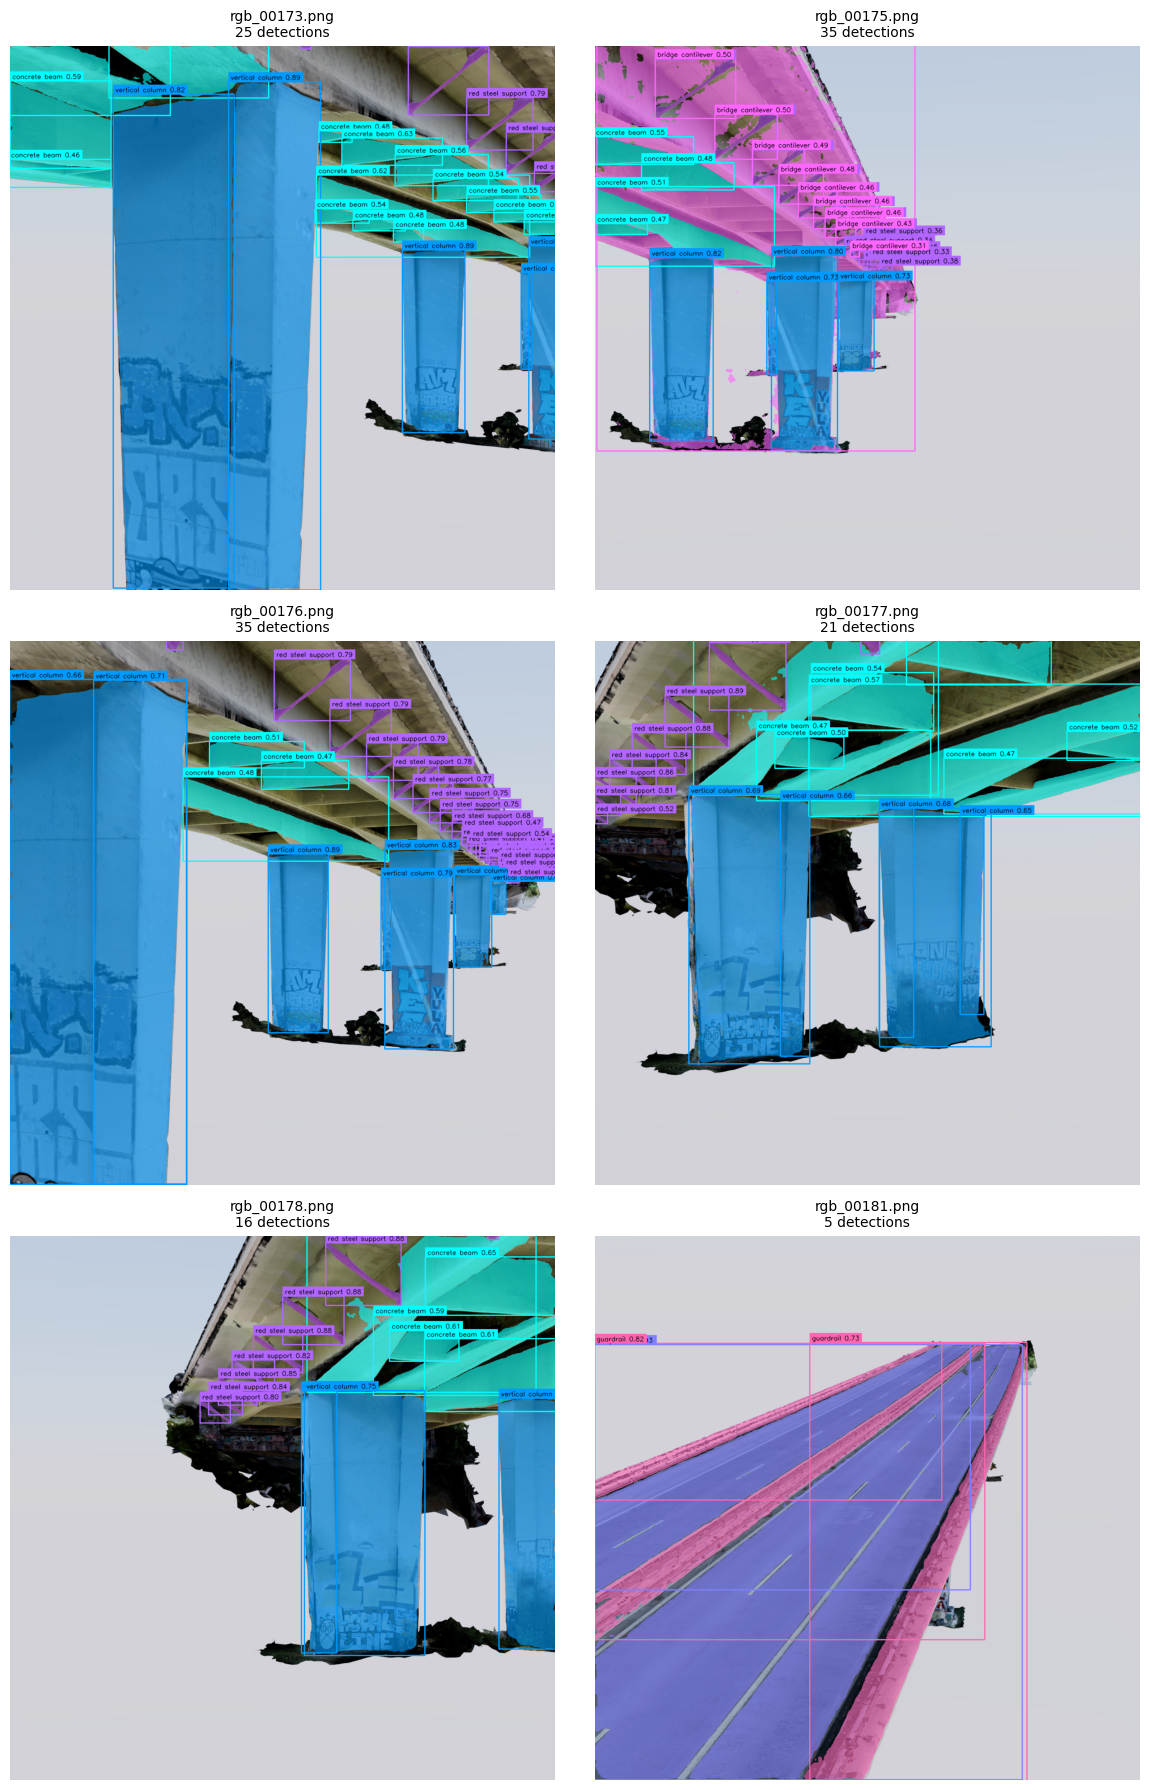


✓ Displayed 6 processed images


In [152]:
# @title
# ==================== VISUALIZE BATCH RESULTS ====================

# Configuration: Choose range of images to display
VIZ_START = 0      # Start index (0-based)
VIZ_END = 40        # End index (inclusive)
VIZ_COLS = 2       # Number of columns in grid

# Validate range
VIZ_START = max(0, min(VIZ_START, len(batch_results) - 1))
VIZ_END = max(VIZ_START, min(VIZ_END, len(batch_results) - 1))

results_to_show = batch_results[VIZ_START:VIZ_END + 1]

print(f" Visualizing {len(results_to_show)} images (index {VIZ_START} to {VIZ_END})")
print(f"   Grid: {VIZ_COLS} columns")

# Calculate grid dimensions
num_images = len(results_to_show)
num_rows = math.ceil(num_images / VIZ_COLS)

# Create figure
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_rows, VIZ_COLS, figsize=(VIZ_COLS * 6, num_rows * 6))
if num_rows == 1 and VIZ_COLS == 1:
    axes = np.array([[axes]])
elif num_rows == 1:
    axes = axes.reshape(1, -1)
elif VIZ_COLS == 1:
    axes = axes.reshape(-1, 1)

# Plot each image
for idx, result in enumerate(results_to_show):
    row = idx // VIZ_COLS
    col = idx % VIZ_COLS
    ax = axes[row, col]

    # Load and annotate image
    img = cv2.imread(result['image_path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Annotate
    mask_annotator = sv.MaskAnnotator(color=COLOR, color_lookup=sv.ColorLookup.CLASS, opacity=0.6)
    box_annotator = sv.BoxAnnotator(color=COLOR, color_lookup=sv.ColorLookup.CLASS, thickness=2)
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.5,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated = mask_annotator.annotate(scene=img_rgb.copy(), detections=result['detections'])
    annotated = box_annotator.annotate(scene=annotated, detections=result['detections'])
    annotated = label_annotator.annotate(scene=annotated, detections=result['detections'], labels=result['labels'])

    # Display
    ax.imshow(annotated)
    ax.set_title(f"{os.path.basename(result['image_path'])}\n{len(result['detections'])} detections", fontsize=10)
    ax.axis('off')

# Hide empty subplots
for idx in range(num_images, num_rows * VIZ_COLS):
    row = idx // VIZ_COLS
    col = idx % VIZ_COLS
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {len(results_to_show)} processed images")

### 8. Save results

In [156]:
# @title
print(" Saving batch results...")

# Create subdirectories
annotated_dir = BATCH_OUTPUT_DIR / "annotated_images"
individual_json_dir = BATCH_OUTPUT_DIR / "individual_results"
annotated_dir.mkdir(exist_ok=True)
individual_json_dir.mkdir(exist_ok=True)

# Helper function to convert mask to RLE
def single_mask_to_rle(mask):
    """Convert single mask to RLE format"""
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

# Batch results container
batch_json_results = {
    "processing_info": {
        "total_images": len(batch_image_files),
        "successfully_processed": len(batch_results),
        "text_prompts": TEXT_PROMPTS,
        "model_used": "SAM 3 (native text-based detection + segmentation)",
        "post_processing_enabled": ENABLE_POST_PROCESSING,
        "post_processing_config": POST_PROCESS_CONFIG if ENABLE_POST_PROCESSING else None
    },
    "images": []
}

# Process each result
for result in tqdm(batch_results, desc="Saving results"):
    img_path = result['image_path']
    image_name = os.path.basename(img_path)
    image_name_no_ext = os.path.splitext(image_name)[0]

    # Load original image for annotation
    img = cv2.imread(img_path)

    # Create annotated image
    mask_annotator = sv.MaskAnnotator(color=COLOR, color_lookup=sv.ColorLookup.CLASS, opacity=0.6)
    box_annotator = sv.BoxAnnotator(color=COLOR, color_lookup=sv.ColorLookup.CLASS, thickness=2)
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.5,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_full = mask_annotator.annotate(scene=img.copy(), detections=result['detections'])
    annotated_full = box_annotator.annotate(scene=annotated_full, detections=result['detections'])
    annotated_full = label_annotator.annotate(scene=annotated_full, detections=result['detections'], labels=result['labels'])

    # Save annotated image
    cv2.imwrite(str(annotated_dir / f"{image_name_no_ext}_annotated.jpg"), annotated_full)

    # Convert masks to RLE
    mask_rles = [single_mask_to_rle(mask) for mask in result['masks']]
    h, w, _ = result['image_source'].shape

    # Create JSON data
    image_result = {
        "image_name": image_name,
        "image_path": img_path,
        "img_width": w,
        "img_height": h,
        "num_detections": len(result['detections']),
        "unique_classes": result['unique_class_names'],
        "class_mapping": result['class_name_to_id'],
        "annotations": [
            {
                "class_name": class_name,
                "class_id": result['class_name_to_id'][class_name],
                "bbox": box.tolist(),
                "segmentation": mask_rle,
                "score": float(score),
                "confidence": float(confidence)
            }
            for class_name, box, mask_rle, score, confidence in zip(
                result['class_names'],
                result['input_boxes'],
                mask_rles,
                result['scores'],
                result['confidences']
            )
        ],
        "box_format": "xyxy"
    }

    # Save individual JSON
    with open(individual_json_dir / f"{image_name_no_ext}.json", "w") as f:
        json.dump(image_result, f, indent=2)

    batch_json_results["images"].append(image_result)

# Save combined batch JSON
with open(BATCH_OUTPUT_DIR / "batch_results.json", "w") as f:
    json.dump(batch_json_results, f, indent=2)

# Summary statistics
all_classes = []
for result in batch_results:
    all_classes.extend(result['class_names'])

class_counts = Counter(all_classes)

print(f"\n Batch processing complete!")
print(f"    Output: {BATCH_OUTPUT_DIR}")
print(f"    Images: {len(batch_results)}")
print(f"    Total detections: {sum(len(r['detections']) for r in batch_results)}")
print(f"    Classes: {dict(class_counts)}")
print(f"\n Output structure:")
print(f"   {BATCH_OUTPUT_DIR}/")
print(f"   ├── annotated_images/     (visualizations)")
print(f"   ├── individual_results/   (per-image JSON)")
print(f"   └── batch_results.json    (combined results)")

 Saving batch results...


Saving results: 100%|██████████| 152/152 [00:31<00:00,  4.78it/s]


 Batch processing complete!
    Output: /content/SAM3_batch_results2
    Images: 152
    Total detections: 1466
    Classes: {'vertical column': 358, 'concrete beam': 368, 'red steel support': 451, 'bridge road': 130, 'guardrail': 159}

 Output structure:
   /content/SAM3_batch_results2/
   ├── annotated_images/     (visualizations)
   ├── individual_results/   (per-image JSON)
   └── batch_results.json    (combined results)


### 9. Download results

In [160]:
# ==================== DOWNLOAD RESULTS ====================

import shutil
import os
from google.colab import files

# Create ZIP file of all results
zip_filename = "/content/SAM3_batch_results.zip"
print(f" Creating ZIP archive...")

# Remove old zip if exists
if os.path.exists(zip_filename):
    os.remove(zip_filename)

# Create new zip
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', BATCH_OUTPUT_DIR)

# Get file size
file_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)

print(f" ZIP created successfully!")
print(f"    File: {zip_filename}")
print(f"    Size: {file_size_mb:.2f} MB")
print(f"\n Starting download...")

# Download the ZIP file
files.download(zip_filename)

print(f" Download initiated! Check your browser's download folder.")

 Creating ZIP archive...
 ZIP created successfully!
    File: /content/SAM3_batch_results.zip
    Size: 80.71 MB

 Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download initiated! Check your browser's download folder.
